In [76]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import kagglehub
import os

In [77]:
# --- 1. Carregamento e Pré-processamento dos Dados ---

# Baixando o dataset do Kaggle usando kagglehub
print("Baixando o dataset do Kaggle...")
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Caminho para o dataset:", path)

Baixando o dataset do Kaggle...
Caminho para o dataset: /kaggle/input/sentiment140


In [78]:
# Construindo o caminho completo para o arquivo CSV
file_path = os.path.join(path, "training.1600000.processed.noemoticon.csv")

# Carregando o dataset
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv(file_path, encoding='ISO-8859-1', names=columns)
print("\nDataset carregado com sucesso.")


Dataset carregado com sucesso.


In [79]:
# Removendo colunas irrelevantes
df = df.drop(['ids', 'date', 'flag', 'user'], axis=1)

# Amostragem do dataset para 50.000 registros
df_neg = df[df['target'] == 0].sample(25000, random_state=42)
df_pos = df[df['target'] == 4].sample(25000, random_state=42)
df_sample = pd.concat([df_neg, df_pos]).reset_index(drop=True)

In [80]:
# Mapeando o rótulo 4 (positivo) para 1
df_sample['target'] = df_sample['target'].replace(4, 1)

print(f"\nNúmero de registros na amostra: {len(df_sample)}")
print(f"Distribuição de sentimentos:\n{df_sample['target'].value_counts()}")


Número de registros na amostra: 50000
Distribuição de sentimentos:
target
0    25000
1    25000
Name: count, dtype: int64


In [81]:
# Função de limpeza de texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

In [82]:
# Aplica a limpeza ao dataset
df_sample['text_cleaned'] = df_sample['text'].apply(clean_text)
df_sample.head()

,target,text,text_cleaned
0,0,@xnausikaax oh no! where did u order from? tha...,oh no where did u order from thats horrible
1,0,A great hard training weekend is over. a coup...,a great hard training weekend is over a coupl...
2,0,"Right, off to work Only 5 hours to go until I...",right off to work only 5 hours to go until im...
3,0,I am craving for japanese food,i am craving for japanese food
4,0,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow gotta work...


In [83]:
# Tokenização e Padding
max_words = 20000
max_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(df_sample['text_cleaned'])

In [84]:
X = tokenizer.texts_to_sequences(df_sample['text_cleaned'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

y = df_sample['target'].values

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nShape dos dados de treino: {X_train.shape}")
print(f"Shape dos dados de teste: {X_test.shape}")


Shape dos dados de treino: (40000, 50)
Shape dos dados de teste: (10000, 50)


In [85]:
embedding_ind = {}
glove = '/content/glove.twitter.27B.100d.txt'
with open(glove, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_ind[word] = coefs

print(f"\nTotal de palavras únicas no GloVe: {len(embedding_ind)}")


Total de palavras únicas no GloVe: 1193514


In [86]:
embedding_dim = 100
lstm_units = 64

embbeding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
      embbeding_vector = embedding_ind.get(word)
      if embbeding_vector is not None:
        embbeding_matrix[i] = embbeding_vector

In [89]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len, weights= [embbeding_matrix],trainable = False ))
model.add(Dropout(0.2))
model.add(LSTM(lstm_units))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\n--- Resumo da Arquitetura da LSTM ---")
model.summary()



--- Resumo da Arquitetura da LSTM ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [90]:
print("\n--- Iniciando o treinamento ---")
history = model.fit(X_train, y_train,
                    epochs=150,
                    batch_size=32,
                    validation_data=(X_test, y_test))


--- Iniciando o treinamento ---
Epoch 1/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6756 - loss: 0.5927 - val_accuracy: 0.7482 - val_loss: 0.5060
Epoch 2/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7512 - loss: 0.5105 - val_accuracy: 0.7827 - val_loss: 0.4674
Epoch 3/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7711 - loss: 0.4870 - val_accuracy: 0.7778 - val_loss: 0.4679
Epoch 4/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7726 - loss: 0.4777 - val_accuracy: 0.7893 - val_loss: 0.4535
Epoch 5/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7783 - loss: 0.4642 - val_accuracy: 0.7632 - val_loss: 0.4846
Epoch 6/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7884 - loss: 0.4525 - val_accuracy: 0.7811 - val_loss: 0.4529
Epoch 7/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7912 - loss: 0.4440 - val_accuracy: 0.7931 - val_loss: 0.4449
Epoch 8/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s

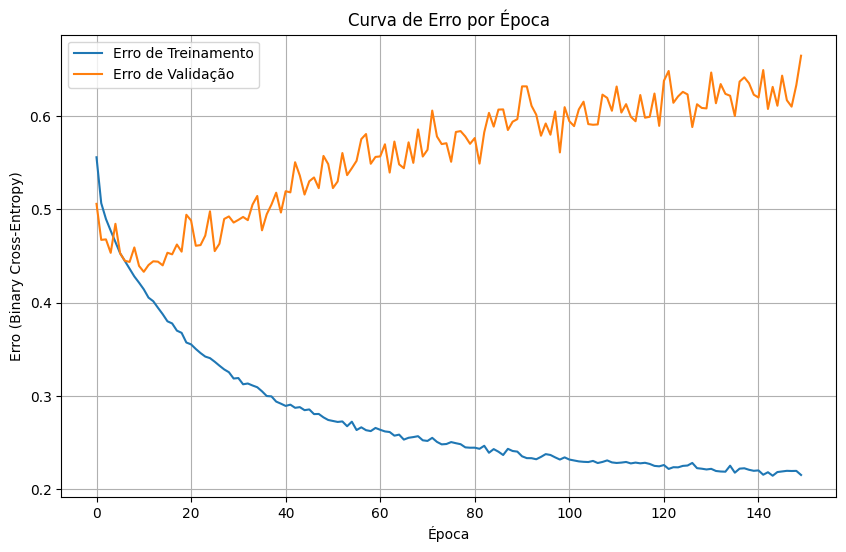

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7756 - loss: 0.6770

Acurácia do modelo no conjunto de teste: 0.7751


In [94]:
# Curva de Erro de Treinamento e Validação
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Erro de Treinamento')
plt.plot(history.history['val_loss'], label='Erro de Validação')
plt.title('Curva de Erro por Época')
plt.xlabel('Época')
plt.ylabel('Erro (Binary Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.show()

# Avaliação no conjunto de teste
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nAcurácia do modelo no conjunto de teste: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


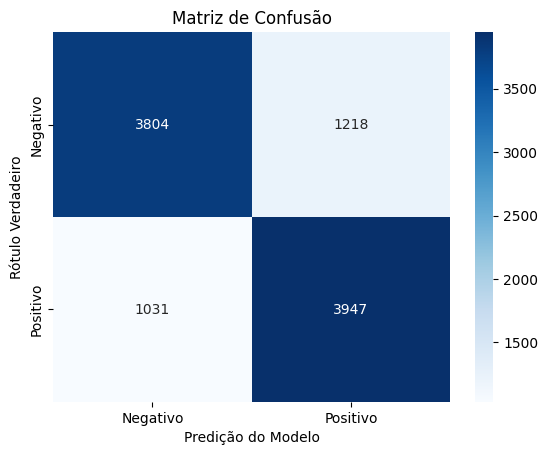

In [92]:

# Matriz de Confusão
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Predição do Modelo')
plt.show()


In [93]:
# Exemplos de Predição
print("\n--- Exemplos de Predições ---")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
original_texts = df_sample.iloc[sample_indices]['text']

for i in range(5):
    index = sample_indices[i]
    original_text = original_texts.iloc[i]
    true_label = "Positivo" if y_test[index] == 1 else "Negativo"

    prediction = model.predict(np.expand_dims(X_test[index], axis=0), verbose=0)[0][0]
    predicted_label = "Positivo" if prediction > 0.5 else "Negativo"

    print(f"\nTweet: {original_text}")
    print(f"Rótulo Verdadeiro: {true_label}")
    print(f"Predição do Modelo: {predicted_label} (Confiança: {prediction:.2f})")

print("\nProcesso concluído.")


--- Exemplos de Predições ---

Tweet: worst job yet. But potentially great ! haha hope i get a site visit.  Still my ipod is dead  im missing it .
Rótulo Verdadeiro: Negativo
Predição do Modelo: Negativo (Confiança: 0.00)

Tweet: some person named stevenlourie wants to fallow me.... kreepy 
Rótulo Verdadeiro: Positivo
Predição do Modelo: Negativo (Confiança: 0.37)

Tweet: @HeriCabral i'm not really pruny anymore 
Rótulo Verdadeiro: Negativo
Predição do Modelo: Negativo (Confiança: 0.06)

Tweet: Ughhhh , . ! i don't want to take this test  we shouldn't have any for the rest of these two weeks . !
Rótulo Verdadeiro: Positivo
Predição do Modelo: Positivo (Confiança: 1.00)

Tweet: @BStyleINC Nope will do WED O didn't tell the mac died June 18, 2009...Let's Us pray  RIP Oct. 2002-Jun. 2009. I'm dprss u guys mademe ;)
Rótulo Verdadeiro: Negativo
Predição do Modelo: Positivo (Confiança: 0.96)

Processo concluído.
